# Mock study of GFR and aging

This notebook accompanies the DAIR3 module on Rigorous Statistical Design.  The objective of this notebook is to demonstrate how mock data can be used to aid in developing an analytic plan, and in conducting power analyses.  These are both essential elements of any proposal for a biomedical research project.

The setting here is a longitudinal observational study where we are looking at the change in glomerular filtration rate (GFR) over time.  Prior research suggests that GFR declines at around 1% per year, but the rate of decrease may differ between subpopulations, e.g. as defined by demographic and clinical factors.

Below we simulate data that is similar to what might be observed in a longitudinal study looking at GFR in relation to age, sex, and diabetes status.  Then we demonstrate some possible analytic approaches and assess the statistical power.

In [13]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng()

Mocking data for a potential research study is a good way to force yourself to think carefully about all aspects of the design.  To mock up data, at a minimum you will need to know what are the exposures and outcomes.  Here, the exposures are age, sex, and diabetes status, and the outcome is GFR.

When the design involves repeated measures, as is the case here, many more factors arise, such as the mean and dispersion of the number of repeated measures per subject, and the correlation among the repeated measures. 

Below we simulate all data using the normal and gamma distributions, which are sufficient for many situations.  Recall that the gamma distribution is parameterized by the shape $\alpha$ and scale $\beta$.  The mean is $\mu = \alpha\beta$ and the variance is $\sigma^2 = \alpha\beta^2$.  You can solve these equations to get $\alpha = \mu^2/\sigma^2$ and $\beta = \sigma^2/\mu$.  Alternatively, we can work with the the mean and the coefficient of variation.  The coefficient of variation is ${\rm C_V} = 1/\sqrt{\alpha}$, so $\alpha = 1/{\rm C_V}^2$ and $\beta = \mu{\rm C_V}^2$.

For a longitudinal study, realistic data must exhibit statistical dependencies that faithfully reflect the expected real-world behavior.  There are many techniques that are useful for simulating realistic dependent data, including hierarchical models and copulas. 

The usual strategy for data simulation is to first generate the sampling structure, i.e. how many observations are made for each individual and when are they made?  Then we simulate exposures (here sex and diabetes), and finally we simulate the response variable.  For analytic purposes, here we will work with log GFR and simulate it directly on the log scale.  Recall that a difference of $u$ on the log scale corresponds to a ratio of approximately $1+u$ on the raw scale, which also corresponds to a change of approximately $100\times u\%$ in percentage terms.  Thus, if age is denominated in years, the slope of log GFR on age should fluctuate around -0.01, if, say, males have 5% lower GFR than females, then the coefficient for male sex should be -0.05.

In the context of a longitudinal study, the notion of _heterogeneity_ corresponds to systematic and stable differences between subjects.  This is distinct from occasion-specific variation that is not a stable characteristic of a subject (the latter might be called "random noise" but that is not a very precise way of putting things).  In the present context, we will consider heterogeneity using hierarchical models in which each subject's GFR measurements follow a line with a latent (unobserved) intercept and slope.  The observed log GFR values do not follow these lines exactly, since there is also occasion-specific variation added to the linear trend.

In such a hierarchical model, the key parameters are the variances of the random intercept, random slope, occasion-specific variation, and the correlation between the random intercept and random slope (the occasion-specific variation is usually assumed to be independent of the random intercept and slope).

In [14]:
def gen_study_data(n_subject, nobs_mn=8, nobs_cv=0.8, ivl_mean=1, ivl_cv=1, age0_mn=45, age0_cv=0.1):
    """
    Generate longitudinal study data.
    
    Parameters
    ----------
    n_subject : number of subjects in the study
    nobs_mn : number of observations years mean
    nobs_cv : number of observations years CV
    ivl_cv : cv of time between assessments (mean interval is always 1)
    age0_mn : mean age at entry
    age0_cv : cv of age at entry
    """
        
    # Generate the follow-up time in years per person
    b = nobs_mn * nobs_cv**2
    a = 1 / nobs_cv**2
    nobs = rng.gamma(a, scale=b, size=n_subject)
    nobs = np.ceil(nobs).astype(int)
    
    # Generate the subject ids in long form
    idx = np.repeat(np.arange(n_subject), repeats=nobs)
    df = pd.DataFrame({"id": idx})
    
    # Generate space between consecutive assessments.
    b = ivl_mean * ivl_cv**2
    a = 1 / ivl_cv**2
    df["ivl"] = rng.gamma(a, scale=b, size=df.shape[0])
    
    # Generate some covariates
    sex = rng.choice(["male", "female"], n_subject)
    df["sex"] = sex[df["id"]]
    dm = rng.choice([0, 1], n_subject, p=[0.8, 0.2])
    df["DM"] = dm[df["id"]]
    
    # Generate baseline age of entry
    b = age0_mn * age0_cv**2
    a = 1 / age0_cv**2
    age0 = rng.gamma(a, scale=b, size=n_subject)
    df["age0"] = age0[df["id"]]
    
    # Generate assessment times and ages
    df["time"] = df.groupby("id")["ivl"].transform(np.cumsum)
    df = df.drop("ivl", axis=1)
    df["age"] = df["age0"] + df["time"]
        
    # Simulate log GFR trajectories
    icept = 0.1*rng.normal(size=n_subject)
    slope = 0.01*rng.normal(size=n_subject)
    df["log_gfr"] = 4.8 - 0.01*df["age"] - 0.25*df["DM"] + 0.02*(df["sex"] == "female")
    df["log_gfr"] += icept[df["id"]] + slope[df["id"]]*df["age"]
       
    # Residual (unexplained) variation
    df["log_gfr"] += 0.4*rng.normal(size=df.shape[0])
        
    # Simulate cardiovascular events
    lp = -3 + 0.01*df["age"] + 0.05*(df["sex"] == "male") + 0.02*df["DM"]
    re = 0.1*rng.normal(size=n_subject)
    lp += re[df["id"]]
    p = 1 / (1 + np.exp(-lp))
    df["cve"] = (rng.uniform(size=df.shape[0]) < p).astype(int)
        
    return df

We can inspect the data by making a scatterplot of log GFR versus age for each subject.

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

n_subject = 50 # Use a smaller number of subjects here since the plots take awhile to render
df = gen_study_data(n_subject)

fig, ax = plt.subplots()
p, = ax.plot([], [], "o", mfc="none")

def plot_subject(i):
    dx = df[df["id"]==i]
    plt.grid(True)
    p.set_data(dx["age"], dx["log_gfr"])
    ax.set_xlabel("Age")
    ax.set_ylabel("log GFR")
    plt.xlim(40, 70)
    ax.set_ylim(3, 6)
    ax.set_title("Subject {}".format(i))
    return p,

ani = animation.FuncAnimation(fig, plot_subject, frames=n_subject, interval=500, blit=True)
html = HTML(ani.to_jshtml())
display(html)
plt.close()

## Starting with a pilot study

_Research question and study design:_ Suppose we have a small pilot study with, say, 200 subjects.  Our goal is to quantify the average (linear) rate of change in GFR, controlling for sex and diabetes status, but not considering the possibility that the rate of change of GFR differs by sex or diabetes status (i.e. there is no heterogeneity in the change in GFR with respect to age that can be explained by these covariates). 

The physical units of GFR are conventionally mL/minute/1.73 meters$^2$, where 1.73 meters$^2$ is the surface area of a typical adult human.  Since we are modeling the log of GFR, and the primary exposure is age (measured in years), the coefficient of age can be interpreted as the relative rate of change (in percentage terms) in GFR per year, e.g. if the slope is -0.01, then GFR is decreasing by 1% per year in the average person.

_Analysis strategy:_ We will conduct the analysis using estimating equations regression (GEE), which is arguably one of the most basic ways to rigorously approach the analysis.  This essentially involves fitting a linear model with (weighted) least squares, and constructing standard errors that reflect the repeated measures in the data.  As with any regression analysis, we must be thoughtful about how the model is specified.  Here we consider a model with main effects for age, sex, and diabetes.

The following cell conducts the analysis on simulated pilot data.  Run the cell a few times and you will see that the standard error for age is often around 0.007 (although it fluctuates a fair amount).  If the SE for a parameter is $s$, as a rough rule of thumb, we have 80% power (at 5% false positives) to detect effects that are $2.9\times s$.  Thus, with a sample size of 200 and SE of 0.007, we would only be able to detect an age slope in the GFR that is at least 0.02 in magnitude.  Since we only anticipate the annual rate of change in GFR to be around -0.01 (1% per year), the study design with 200 subjects is underpowered.  But suppose we increase the sample size by a factor of 4 (to 800).  Then the standard error would decline by a factor of 2, perhaps to around 0.0035, and the detectable effect size is close to 0.01. 

In [16]:
n_subject = 200
df = gen_study_data(n_subject)

fml = "log_gfr ~ age + sex + DM"
m0 = sm.GEE.from_formula(fml, df["id"], data=df)
r0 = m0.fit()
r0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                     log_gfr   No. Observations:                 1661
Model:                                 GEE   No. clusters:                      200
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  34
Family:                           Gaussian   Mean cluster size:                 8.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 13 May 2025   Scale:                           0.479
Covariance type:                    robust   Time:                         10:20:00
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.5728      0.286     16.009      0.000       4.013       5.133
sex[T.male]     0.0239      0.101      0.238      0.812      -0.173       0.221
age            -0.0053      0.006     -0.931      0.352      -0.016       0.006
DM             -0.3935      0.122     -3.238      0.001      -0.632      -0.155
==============================================================================
Skew:                         -0.1406   Kurtosis:                       0.0701
Centered skew:                 0.0749   Centered kurtosis:             -0.0063
==============================================================================
"""

The simulation study below demonstrates the power at n=800.

In [17]:
n_subject = 800
fml = "log_gfr ~ age + sex + DM"

df = gen_study_data(n_subject)
m0 = sm.GEE.from_formula(fml, df["id"], data=df)
r0 = m0.fit()
r0.summary()
r0.tvalues["age"]

nrep = 100
zscores = np.empty(nrep)
for j in range(nrep):
    df = gen_study_data(n_subject)
    m0 = sm.GEE.from_formula(fml, df["id"], data=df)
    r0 = m0.fit()
    r0.summary()
    zscores[j] = r0.tvalues["age"]

(np.abs(zscores) > 2).mean()

0.82

Next we consider a model that allows the slope of log GFR on age to differ by sex and by diabetes status.  This is accomplished by including interactions in the model.

In [18]:
df = gen_study_data(n_subject)
fml1 = "log_gfr ~ age * (sex + DM)"
m0 = sm.GEE.from_formula(fml, df["id"], data=df)
r0 = m0.fit()
r0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                     log_gfr   No. Observations:                 6693
Model:                                 GEE   No. clusters:                      800
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  43
Family:                           Gaussian   Mean cluster size:                 8.4
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 13 May 2025   Scale:                           0.456
Covariance type:                    robust   Time:                         10:20:12
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9889      0.175     28.465      0.000       4.645       5.332
sex[T.male]     0.0164      0.053      0.310      0.757      -0.087       0.120
age            -0.0139      0.004     -3.925      0.000      -0.021      -0.007
DM             -0.2009      0.068     -2.947      0.003      -0.335      -0.067
==============================================================================
Skew:                         -0.1081   Kurtosis:                       0.1423
Centered skew:                -0.0244   Centered kurtosis:              0.1555
==============================================================================
"""

What is the cost (in terms of statistical power) of considering interactions?  Below we consider a small simulation study to assess the standard error for the interaction term, which is the difference between the main effects of age between sexes or between people with and without diabetes.

(array([ 5., 24., 28., 24., 14.,  2.,  1.,  0.,  1.,  1.]),
 array([0.00689053, 0.0085648 , 0.01023908, 0.01191336, 0.01358764,
        0.01526192, 0.0169362 , 0.01861047, 0.02028475, 0.02195903,
        0.02363331]),
 <BarContainer object of 10 artists>)

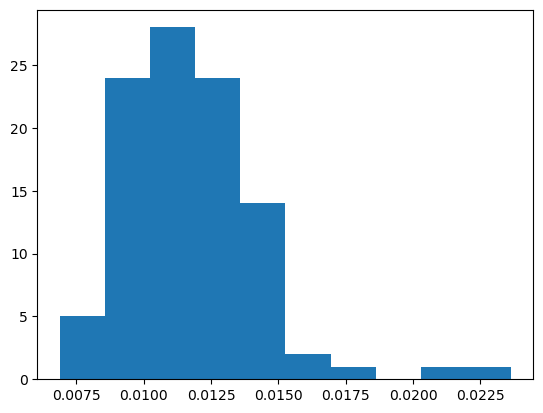

In [19]:
nrep = 100
n_subject = 200
se = np.empty(nrep)
for i in range(nrep):
    df = gen_study_data(n_subject)
    r1 = sm.GEE.from_formula(fml1, df["id"], data=df).fit()
    se[i] = r1.bse[3]
    
plt.hist(se)

The modal value of the standard error is around 0.01, so the detectable effect size is around 0.03.  The detectable effect size is proportional to the standard error, which is inversely proportional to the square root of the sample size.  

Recall that when ignoring heterogeneity above, the slope of age on GFR was around -0.01 (this is baked into the simulation, but in practice we would only see the estimated value from the data).  Arguably, it would not be likely for the difference of GFRs between demographic groups to exceed half of the main effect (i.e. it is unlikely to be bigger than 0.005 in magnitude).  Suppose we wish to find the factor $f$ by which we must increase our sample size in order for the detectable effect size (for the interaction) to be 0.005.  That is, our pilot data sample size is $n$, and we would run a future study with sample size $f\cdot n$. We need to solve the equation $0.03/\sqrt{f} = 0.005$, which yields a factor of around 36 -- that is, we need to increase the sample size of the pilot study by a factor of 36 to reliably detect an interaction whose magnitude is half the magnitude of the main effect. 

Recall that to detect the main effect, we needed to increase the sample size of the pilot study by a factor of 4.  Thus, the interaction in this case requires 36/4 = 9 times more data to detect.  This aligns with [Gelman's](https://statmodeling.stat.columbia.edu/2018/03/15/need16/) claim that as a rule of thumb you need 16 times more data to detect an interaction than to detect a main effect.

## Frequency of observations

In designing a longitudinal study on a fixed budget, there is usually a tradeoff between the total number of (distinct) people, and the number of observations (follow-up times) per person.  Both cost resources, but it typically is more expensive to recruit additional subjects that it is to get the existing subjects to be assessed more frequently.  However, the gain in power is usually greater when recruiting additional subjects.  An additional factor is the total duration of the study, which has implications for logistics as well as when study results can be reported.

Below we consider four designs: (1) 200 people with an average of 8 follow-ups per person at one year intervals, (2) 200 people with an average of 16 follow-ups per person at 6 month intervals, (3) 200 people with an average of 16 follow-ups per person at 1 year intervals, (4) 400 people with an average of 8 follow-ups per person at 1 year intervals.

Compare the standard errors for the age coefficient to get a sense for the relative powers of these designs.

In [32]:
n_subject = 400
bse1 = np.zeros(4)
bse2 = np.zeros(4)
bse3 = np.zeros(4)
bse4 = np.zeros(4)
nrep = 20

for k in range(nrep):
    df1 = gen_study_data(n_subject, nobs_mn=8, ivl_mean=1)
    r1 = sm.GEE.from_formula(fml, df1["id"], data=df1).fit()
    bse1 += r1.bse
    
    df2 = gen_study_data(n_subject, nobs_mn=16, ivl_mean=0.5)
    r2 = sm.GEE.from_formula(fml, df2["id"], data=df2).fit()
    bse2 += r2.bse

    df3 = gen_study_data(n_subject, nobs_mn=16, ivl_mean=1)
    r3 = sm.GEE.from_formula(fml, df3["id"], data=df3).fit()
    bse3 += r3.bse

    df4 = gen_study_data(2*n_subject, nobs_mn=8, ivl_mean=1)
    r4 = sm.GEE.from_formula(fml, df4["id"], data=df4).fit()
    bse4 += r4.bse

print(bse1)
print(bse2)
print(bse3)
print(bse4)

Intercept      4.523940
sex[T.male]    1.393245
age            0.090479
DM             1.761548
dtype: float64
Intercept      4.460605
sex[T.male]    1.390614
age            0.090366
DM             1.724004
dtype: float64
Intercept      3.420426
sex[T.male]    1.625019
age            0.064496
DM             1.946301
dtype: float64
Intercept      3.402251
sex[T.male]    0.994564
age            0.068454
DM             1.201501
dtype: float64
